# Dow Jones Data Analysis

Here we analize historical stock prices (2006-2018) for 29 companies on the Down Jones Industrial Average (DJIA):
MMM, 3M
AXP, American Express Company
AAPL, Apple Inc.
BA, Boeing Co.
CTA, Caterpillar Inc.
CVX, Chevron Corp.
etc

For ease of computation, only 2 relevant quantities are considered for each stock: **Opening price** and **Volume**. The first is representative of the price for the stock during the day, while the second reports how 'important' is the stock.

Data was obtained from Kaggle ['DJIA 30 Stock Time Series'](https://www.kaggle.com/datasets/szrlee/stock-time-series-20050101-to-20171231?select=AXP_2006-01-01_to_2018-01-01.csv). This notebook can be accesed uing [this link](https://drive.google.com/file/d/1H0I3sc2IIxzSMIAaLSmUhMocAL8IlyIY/view?usp=sharing).

## Data loading

Data is loaded locally from files downloaded from ['DJIA 30 Stock Time Series'](https://www.kaggle.com/datasets/szrlee/stock-time-series-20050101-to-20171231?select=AXP_2006-01-01_to_2018-01-01.csv).
This data is assumed to have *multiplicative noise*,
$$ \text{Data} = \text{TrueValue} * \text{Noise}_+.$$
This assumption, common in economics, comes from observing that the quantities of interest are positive and they tend grow exponentally. Noise is also assumed to be positive.

Under the assumption of multiplicative noise, the data is log-transformed after loading and then treated 'as usual'. 

In [1]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')
#patt = '/content/drive/MyDrive/Work/2022_1_spring/Class/project' #path
patt ='.'

In [3]:
stocks = ['MMM', 'AXP', 'AAPL', 'BA', 'CAT', 'CVX', 'CSCO', 'KO', 'DIS', 'XOM', 
          'GE','GS', 'HD', 'IBM', 'INTC', 'JNJ', 'JPM', 'MCD', 'MRK', 'MSFT', 
          'NKE', 'PFE', 'PG', 'TRV', 'UTX', 'UNH', 'VZ', 'WMT', 'GOOGL', 
          'AMZN']#, 'AABA'

In [4]:
start = datetime.datetime(2006, 1, 1)
end   = datetime.datetime(2018, 1, 1)
start_date_str = str(start.date())
end_date_str   = str(end.date())

In [5]:
all_stocks = 0 # reinitialization for re-runs
for (i, ticker) in enumerate(stocks):
  file_name = patt + '/stocks/' + ticker + '_' + start_date_str + '_to_' + end_date_str + '.csv'
  data = pd.read_csv(file_name, parse_dates=['Date'], index_col=['Date'])
  lab1 = ticker+'_opn'
  lab2 = ticker+'_vol'
  data = data.rename(columns={'Open': lab1, 'Volume': lab2})
  #data[lab2] = np.log(data[lab2])
  if i==0:
    all_stocks = np.log(data[[lab1, lab2]])
    opn_all    = [lab1]
    vol_all    = [lab2]
  else:
    all_stocks[[lab1,lab2]] = np.log(data[[lab1, lab2]])
    opn_all.append( lab1 )
    vol_all.append( lab2 )
all_stocks = all_stocks.dropna()
all_stocks = all_stocks.astype('float64')

C:\Users\jcnoc\anaconda3\lib\site-packages\pandas\core\internals\blocks.py:402: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


Representative plot with prices and volumes from 3M, American Express and Apple Inc.

C:\Users\jcnoc\AppData\Local\Temp\ipykernel_14604\91111162.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


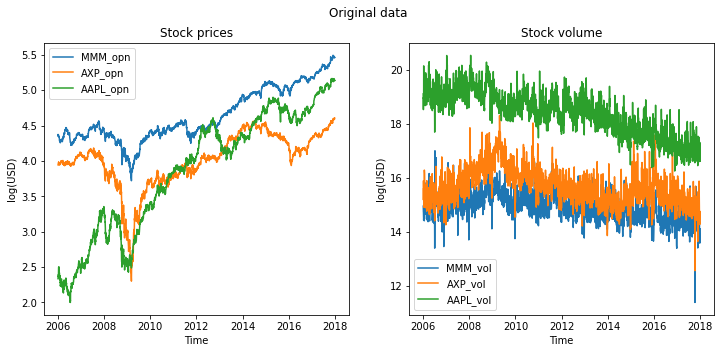

In [6]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=False, figsize=(12,5))
fig.suptitle('Original data')
for i in range(3):
  ax[0].plot(all_stocks[opn_all[i]],label=opn_all[i])
  ax[1].plot((all_stocks[vol_all[i]]),label=vol_all[i])
ax[0].set_title('Stock prices')
ax[1].set_title('Stock volume')

for axi in fig.get_axes():
  axi.set(xlabel='Time')
  axi.set(ylabel='log(USD)')

ax[0].legend(loc="upper left")
ax[1].legend(loc="lower left")
fig.show()

## Pre-processing

Data is normalized to have zero median and unit median error; this condition replaces zero mean and unit variance for robustness and snobbery. 

Fast oscillations are removed from data by using a low-pass Butterworth filter with a bandwidth equivalent to 1 month.

In [7]:
MED1 = [] #vector of medians
MED2 = [] #vector of mean absolute error
for i in all_stocks.columns:
  med1 = np.median( all_stocks[i] )
  MED1.append(med1)
  all_stocks[i] = all_stocks[i]-med1
  med2 = np.median(abs( all_stocks[i] ))
  all_stocks[i] = all_stocks[i]/med2
  MED2.append(med2)

C:\Users\jcnoc\AppData\Local\Temp\ipykernel_14604\3276432903.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


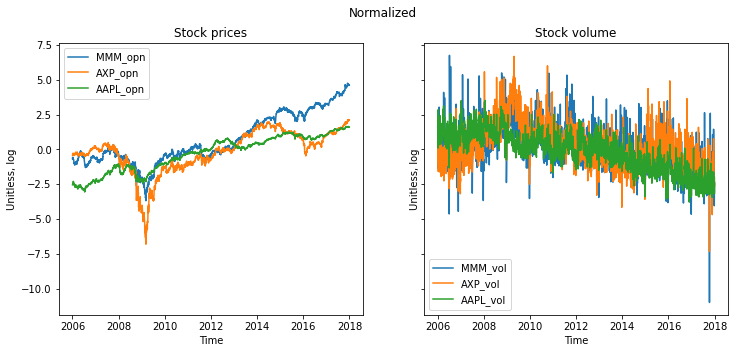

In [8]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(12,5))
fig.suptitle('Normalized')
for i in range(3):
  ax[0].plot(all_stocks[opn_all[i]],label=opn_all[i])
  ax[1].plot((all_stocks[vol_all[i]]),label=vol_all[i])
ax[0].set_title('Stock prices')
ax[1].set_title('Stock volume')

for axi in fig.get_axes():
  axi.set(xlabel='Time')
  axi.set(ylabel='Unitless, log')

ax[0].legend(loc="upper left")
ax[1].legend(loc="lower left")
fig.show()

In [9]:
from scipy.signal import butter,filtfilt# Filter requirements.

def butter_lowpass(data, cutoff, fs, order):
  nyq = 365/2 
  normal_cutoff = cutoff / nyq
  # Get the filter coefficients 
  b, a = butter(order, normal_cutoff, btype='low', analog=False)
  y = filtfilt(b, a, data)
  return y
def butter_highpass(data, cutoff, fs, order):
  nyq = 365/2 
  normal_cutoff = cutoff / nyq
  # Get the filter coefficients 
  b, a = butter(order, normal_cutoff, btype='high', analog=False)
  y = filtfilt(b, a, data)
  return y

In [10]:
all_stocks_filtered = all_stocks.copy()
for i in all_stocks.columns:
  all_stocks_filtered[i] = butter_lowpass(all_stocks[i], 12, 365, 4)

C:\Users\jcnoc\AppData\Local\Temp\ipykernel_14604\738128741.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


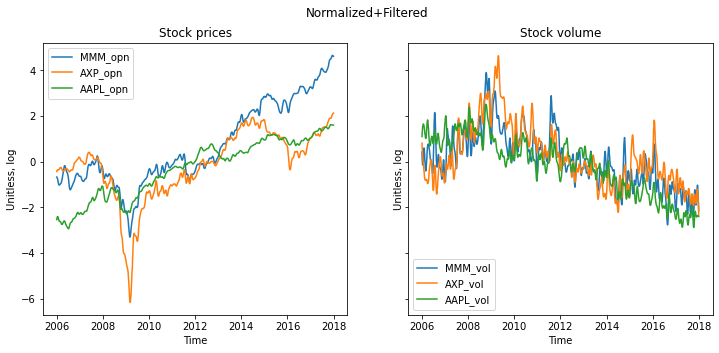

In [11]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(12,5))
fig.suptitle('Normalized+Filtered')
for i in range(3):
  ax[0].plot(all_stocks_filtered[opn_all[i]],label=opn_all[i])
  ax[1].plot((all_stocks_filtered[vol_all[i]]),label=vol_all[i])
ax[0].set_title('Stock prices')
ax[1].set_title('Stock volume')

for axi in fig.get_axes():
  axi.set(xlabel='Time')
  axi.set(ylabel='Unitless, log')

ax[0].legend(loc="upper left")
ax[1].legend(loc="lower left")
fig.show()

For ease of coding, the filtered data is used as a default. The original data is also kept, additionally to the data without the 'Date' column.

In [12]:
data  = all_stocks_filtered
dataO = all_stocks
dataP = data.copy() # data with 'picky' formatting
dataP = dataP.dropna()
dataP = dataP.reset_index() 
dataP = dataP.drop(columns='Date')
dataP = dataP.astype('float64')
dataP = dataP.to_numpy()
dat   = data.reset_index()['Date']

To measure the quality of this filtered data, consider the joint histogram for residuals. 

C:\Users\jcnoc\AppData\Local\Temp\ipykernel_14604\2738705076.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


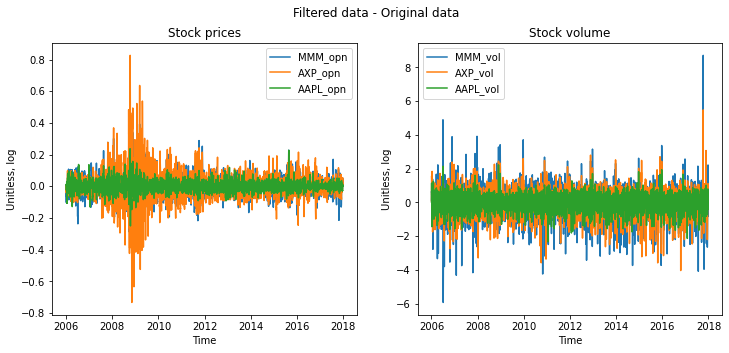

In [13]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=False, figsize=(12,5))
fig.suptitle('Filtered data - Original data')
for i in range(3):
  ax[0].plot(data[opn_all[i]]-dataO[opn_all[i]],label=opn_all[i])
  ax[1].plot((data[vol_all[i]]-dataO[vol_all[i]]),label=vol_all[i])
ax[0].set_title('Stock prices')
ax[1].set_title('Stock volume')

for axi in fig.get_axes():
  axi.set(xlabel='Time')
  axi.set(ylabel='Unitless, log')

ax[0].legend(loc="upper right")
ax[1].legend(loc="upper left")
fig.show()

## Analysis with SINDy

### Construction of the model

In [14]:
#%%capture
#!pip install pysindy

In [15]:
import pysindy as ps

The setup for the SINDy model is quite default: numerical differentiation of order 2 and a polynomial library up to degree 3. Stepwise sparse regression (SSR) greedy algorithm was selected since it's working principle appeals to me.

In [62]:
model = ps.SINDy(
    differentiation_method = ps.FiniteDifference(order=2),
    feature_library        = ps.PolynomialLibrary(degree=2),
    #optimizer              = ps.SSR(alpha=500, max_iter=40, verbose=True),#, kappa=10^(-6)
    optimizer              = ps.STLSQ(alpha=0.0000001, threshold=0.05, verbose=True),
    feature_names          = data.columns
)
time = np.array(range(data.shape[0]))/30

In [ ]:
model.fit(x=dataP, t=time)

 Iteration ... |y - Xw|^2 ...  a * |w|_2 ...      |w|_0 ... Total error: |y - Xw|^2 + a * |w|_2
         0 ... 3.5304e+05 ... 1.0038e-03 ...      64975 ... 3.5304e+05
         1 ... 7.2062e+04 ... 1.0529e-03 ...      60459 ... 7.2062e+04


### Analysis of the model

The stability of the model can't be judged from the coefficients alone. We can, however, check how many non-zero coefficients there are on the model, relative to the total number of coefficients.



In [ ]:
A = model.coefficients()
100*len(A[A!=0])/(len(A[A!=0])+len(A[A==0]))

In [ ]:
A[A!=0

In [ ]:
plt.hist(A[:])

### Data prediction

Using the SINDy model, first the original data is reconstructed and then 2 years of data are predicted.

In [ ]:
# for fancy labelling
d_lab = pd. date_range(start="2006-01-01",end="2020-01-01"). to_pydatetime(). tolist()
n_pts = len(d_lab)
last  = data.reset_index()['Date'] # last point on dataset
last  = last[len(last)-1]
time2 = np.array(range(n_pts))

In [ ]:
sim = model.simulate(dataP[0,:], t=time2)

In [ ]:
for i in range(3):
  fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(12,5))
  fig.suptitle('Predicted data comparison')
  j = 2*i
  ax[0].set_title(data.columns[j])
  ax[1].set_title(data.columns[j+1])

  for k in range(2):
    ax[k].plot(data.reset_index()['Date'],data.to_numpy().T[j+k],label='Original data')
    ax[k].plot(d_lab,sim.T[j+k],label='Prediction')
    ax[k].axvline(x=last, color='g', linestyle='--',label='Last measurement')
    ax[k].set(xlabel='Time')
    ax[k].set(ylabel='Unitless, log')

  ax[0].legend(loc="upper left")
  ax[1].legend(loc="lower left")
  fig.show()